In [1]:
import math
import warnings
from collections import namedtuple

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns

Equity = namedtuple('Equity', ['market', 'real_estate'])


/home/benj/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
sns.set()

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6)

Populating the interactive namespace from numpy and matplotlib


In [4]:
def get_params(expected_market_return=1.06, expected_salary_growth=1.04, expected_home_appreciation=1.02):
    avg_market_rtn = np.random.randn() * 0.015 + expected_market_return
    # keep real estate close to inflation growth. unlikely to plummet horrifically below, and don't want to bet on
    # huge real estate returns
    avg_real_estate_rtn = np.random.randn() * 0.0075 + expected_home_appreciation
    avg_salary_growth = np.random.randn() * 0.02 + expected_salary_growth
    
    return avg_market_rtn, avg_real_estate_rtn, avg_salary_growth

## Simulation Parameters

In [5]:
#### fixed parameters
home_price = 320000 # calgary median attached home price 
down = 0.1
amortization = 25
property_tax_rate = 0.0066540
interest_rate = 1.03
household_income = 100000 # median household income


# rent and maintenance
rent_monthly = 1800 # guessing cost of renting a row house?
maintenance_monthly = 2200 / 12

# monthly spend and surplus
e_monthly_spend = 2500
std_monthly = 1000

inflation = 1.02
taxes = 0.35

stock_home_split = 0.5


def create_dynamic_dataset(expected_market_return=1.06, expected_home_appreciation=1.02):
    # annual expected market returns. Scaled down from S&P
    
    e_mkt, e_re, e_sg = get_params(expected_market_return=expected_market_return,
                                   expected_home_appreciation=expected_home_appreciation)
    
    std_mkt = 0.10
    e_mkt_mnth = e_mkt ** (1/12)
    std_mkt_mnth = std_mkt / math.sqrt(12)

    # annual expected real estate returns. Expecting inflation since I don't see this as an 'investment'
    # and it's all about if it helps me build more net worth
    std_re = 0.02
    std_re_mnth = std_re / math.sqrt(12)
    e_re_mnth = e_re ** (1/12)

    interest_rate = 1.027
    amortization = 25
    down_payment = 0.05

    std_sg = 0.02

    mkt_rtns = pd.Series((np.random.randn(nmonths) * std_mkt_mnth + e_mkt_mnth), name='market_rtns')
    
    salary_growth = pd.Series(np.random.randn(amortization) * std_sg + e_sg).cumprod()
    income = (household_income * salary_growth)
    take_home = pd.Series(np.repeat(income.values, 12, axis=0), name='income') / 12 * (1 - taxes)

    he_growth = pd.Series(np.random.randn(nmonths) * std_re_mnth + e_re_mnth).cumprod()
    home_value = pd.Series(np.repeat(home_price, len(take_home))) * he_growth
    home_value.name = 'home_value'
    
    return pd.concat([mkt_rtns, take_home, home_value], axis=1)




In [6]:
nmonths = 25 * 12
ir = (interest_rate - 1) / 12
loan = home_price - home_price * down

def calculate_amortization_amount(principal, interest_rate, period):
    x = (1 + interest_rate) ** period
    return principal * (interest_rate * x) / (x - 1)

def amortization_schedule(principal, interest_rate, period):
    amortization_amount = calculate_amortization_amount(principal, interest_rate, period)
    number = 1
    balance = principal
    while number <= period:
        interest = balance * interest_rate
        principal = amortization_amount - interest
        balance = balance - principal
        yield interest, principal, balance
        number += 1
        
class Mortgage():
    def __init__(self, principal, interest_rate, period):
        
        amortization_amount = calculate_amortization_amount(principal, interest_rate, period)
        
        self.amortization_amount = amortization_amount
        self.principal = principal
        self.interest_rate = interest_rate
        self.period = period
        self.balance = self.principal
    
    def make_payment(self,amount):
        interest = self.balance * self.interest_rate
        principal = amount - interest
        if principal > self.balance:
            return_of_capital = principal - self.balance
            self.balance = 0
            return interest, return_of_capital
        self.balance -= principal
        return interest, 0

    @property
    def pct_paid_off(self):
        return 1 - self.balance / self.principal
    
    @property
    def is_paid_off(self):
        return self.balance <= 0 #handle small negative numbers
    
        
    def amortization_schedule(self):
        amortization_amount = calculate_amortization_amount(self.principal, self.interest_rate, self.period)
        number = 1
        balance = self.principal
        while number <= self.period:
            interest = balance * self.interest_rate
            principal = self.amortization_amount - interest
            balance = balance - principal
            yield interest, principal, balance
            number += 1

In [7]:
def create_fixed_dataset(rental_income=None, years_renting=None):
    df_mortgage = pd.DataFrame(list(amortization_schedule(loan, ir, nmonths)), columns=['interest', 'principal', 'balance'])

    inflation_growth = np.repeat(1.02 ** (1/12), amortization * 12).cumprod() 

    rent = pd.Series(np.repeat(rent_monthly, len(df_mortgage)), name='rent') * inflation_growth
    expenses = pd.Series((np.random.randn(nmonths) * std_monthly + e_monthly_spend), name='expenses') * inflation_growth
    maint = pd.Series(np.repeat(maintenance_monthly, len(df_mortgage)), name='maintenance') * inflation_growth
    prop_tax = pd.Series(np.repeat(home_price * property_tax_rate / 12, len(df_mortgage)), name='property_tax')
    
    if rental_income:
        ri = pd.Series(np.repeat(rental_income, years_renting*12), name='rental_income')
        ri = ri.reindex(df_mortgage.index).fillna(0)
        ri *= inflation_growth
        return pd.concat([df_mortgage, rent, expenses, maint, prop_tax, ri], axis=1)
        
    return pd.concat([df_mortgage, rent, expenses, maint, prop_tax], axis=1)

In [8]:
df_fixed = create_fixed_dataset()
df_fixed.head()

,interest,principal,balance,rent,expenses,maintenance,property_tax
0,720.000000,645.728584,287354.271416,1802.972846,2757.793615,183.636123,177.44
1,718.385679,647.342905,286706.928511,1805.950603,3218.382449,183.939413,177.44
2,716.767321,648.961263,286057.967248,1808.933277,1539.073334,184.243204,177.44
3,715.144918,650.583666,285407.383582,1811.920877,1859.649741,184.547497,177.44
4,713.518459,652.210125,284755.173457,1814.913412,2230.930219,184.852292,177.44


In [9]:
create_dynamic_dataset().head()

,market_rtns,income,home_value
0,0.978787,5753.759698,320838.804867
1,1.056975,5753.759698,319490.311707
2,1.016266,5753.759698,323017.939920
3,0.992505,5753.759698,322488.708675
4,1.020313,5753.759698,324584.209076


In [10]:
def simulate(surplus_market_alloc=0.5, rental_income=None,
             years_renting=None, expected_market_return=1.06, expected_home_appreciation=1.02):
    df_fixed = create_fixed_dataset(rental_income, years_renting)
    df_dynamic = create_dynamic_dataset(expected_market_return=expected_market_return, 
                                       expected_home_appreciation=expected_home_appreciation)
    df = pd.concat([df_fixed, df_dynamic], axis=1)
    
    personal_equity_home = [Equity(0, home_price * down)]
    personal_equity_no_home = [Equity(home_price * down, 0)]
    invested_rent = [0]
    
    burned_money_home = [0]
    burned_money_no_home = [0]
    
    mortgage = Mortgage(loan, ir, nmonths)
    min_payment = mortgage.amortization_amount
    
    payments_not_made = []
    has_renter = 'rental_income' in df.columns
    for row in df.itertuples():
        surplus = row.income - row.expenses

        ##### home ownership block ####
        surplus_home = surplus - row.maintenance - min_payment - row.property_tax
        if has_renter:
            surplus_home += row.rental_income
        
        if surplus_home < 0:
            payments_not_made.append(1)
            towards_market = 0
            # insufficient capital, put everything you can towards the home. Assume in real life
            # would have enough contingency and float that this wouldn't result in late payments
            towards_home = surplus - row.maintenance - row.property_tax
            if towards_home < 0:
                towards_home = 0
        else:
            payments_not_made.append(0)      
            towards_home = min_payment + surplus_home * (1 - surplus_market_alloc)
            towards_market = surplus_home * surplus_market_alloc
        
        if mortgage.is_paid_off:
            interest_paid = 0
            # nothing left to pay, dump it in the market
            towards_market += towards_home
        else:
            # on the last payment, we pay off more than we need. get back the excess principal and reinvest it
            interest_paid, excess_principal = mortgage.make_payment(towards_home)
            towards_market += excess_principal
            
        burned_money_home.append(burned_money_home[-1] + interest_paid + row.maintenance + row.property_tax)
        
        pct_home_owned = down + (1 - down) * mortgage.pct_paid_off
        home_equity = row.home_value * pct_home_owned
        
        portfolio_value = personal_equity_home[-1][0] * row.market_rtns
        portfolio_value = max(0, portfolio_value)
        market_equity = portfolio_value + towards_market
        
        personal_equity_home.append(Equity(market_equity, home_equity))
        
        #### rent it block ####
        rental_surplus = surplus - row.rent
        if rental_surplus < 0:
            rental_surplus = 0
        invested_rent.append(invested_rent[-1] + rental_surplus)
        towards_market = rental_surplus
        portfolio_value2 = personal_equity_no_home[-1][0] * row.market_rtns
        portfolio_value2 = max(0, portfolio_value2)
        burned_money_no_home.append(burned_money_no_home[-1] + row.rent)
        personal_equity_no_home.append(Equity(portfolio_value2+towards_market, 0))
        
    df_results = pd.DataFrame(data = {
        'own_market': [x.market for x in personal_equity_home],
        'own_home': [x.real_estate for x in personal_equity_home],
        'rent_market': [x.market for x in personal_equity_no_home],
        'rent_home': [x.real_estate for x in personal_equity_no_home],
        'burned_home': burned_money_home,
        'burned_rent': burned_money_no_home,
        'rental_invested': invested_rent
    })
    
    df_results['home'] = df_results.own_market + df_results.own_home
    df_results['rent'] = df_results.rent_home + df_results.rent_market
    
    return df_results


In [11]:
sample = simulate(surplus_market_alloc=stock_home_split)

In [12]:
sample.tail()

,own_market,own_home,rent_market,rent_home,burned_home,burned_rent,rental_invested,home,rent
296,1.270744e+06,588738.095747,1.113336e+06,0,180045.618852,687543.708754,718115.587658,1.859482e+06,1.113336e+06
297,1.310664e+06,591459.655448,1.146977e+06,0,180522.351250,690482.215934,724755.316755,1.902123e+06,1.146977e+06
298,1.340396e+06,586671.572894,1.171150e+06,0,180999.577953,693425.576298,727255.228091,1.927068e+06,1.171150e+06
299,1.336984e+06,587376.890501,1.166299e+06,0,181477.299779,696373.797860,729541.001410,1.924361e+06,1.166299e+06
300,1.337860e+06,588315.742352,1.165234e+06,0,181955.517545,699326.888650,729541.001410,1.926176e+06,1.165234e+06


In [13]:
def monte_carlo(nruns, sim_params):
    rents = []
    owns = []
    for i in range(nruns):
        sim = simulate(**sim_params)
        rents.append(sim.rent)
        owns.append(sim.home)

    df_rents = pd.concat(rents, axis=1, keys=range(nruns))
    df_owns = pd.concat(owns, axis=1, keys=range(nruns))
    ncols = min(nruns, 200)
    ax = df_rents[list(range(ncols))].plot(alpha=0.1, legend=False, color='r', logy=True)
    df_owns[list(range(ncols))].plot(alpha=0.1, legend=False, color='b', logy=True, ax=ax);
    plt.show()
    
    end_value_own = df_owns.iloc[-1]
    end_value_rent = df_rents.iloc[-1]
    sns.distplot(end_value_own, hist=False);
    sns.distplot(end_value_rent, hist=False, color='red');
    plt.show()
    
    own_med = round(end_value_own.median())
    own_rent = round(end_value_rent.median())
    print(f'Median net worth: own {own_med} | rent {own_rent}')
    own_med = round(end_value_own.mean())
    own_rent = round(end_value_rent.mean())
    print(f'Mean net worth: own {own_med} | rent {own_rent}')
    print(stats.ttest_rel(end_value_own, end_value_rent))

## No renter, baseline

---------- no renter baseline ---------------


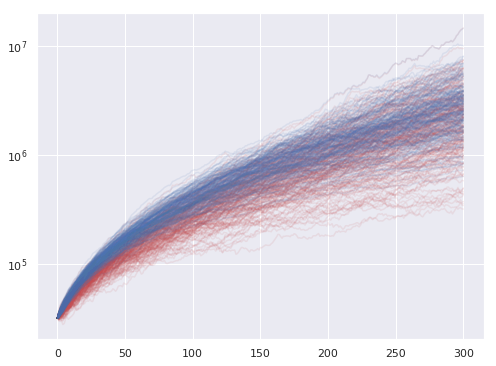

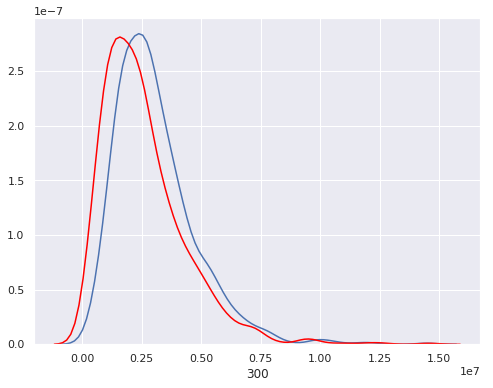

Median net worth: own 2730786.0 | rent 2226536.0
Mean net worth: own 3074334.0 | rent 2571185.0
Ttest_relResult(statistic=59.71249926090161, pvalue=0.0)
-------------------------
---------- no renter invest all surplus in market ---------------


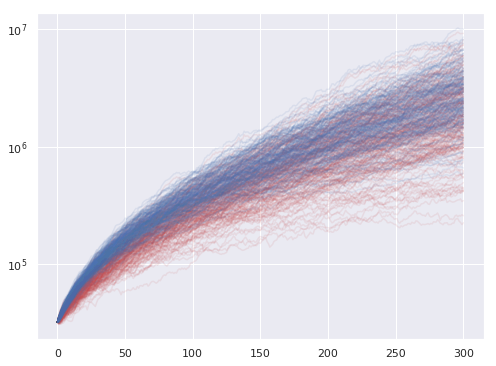

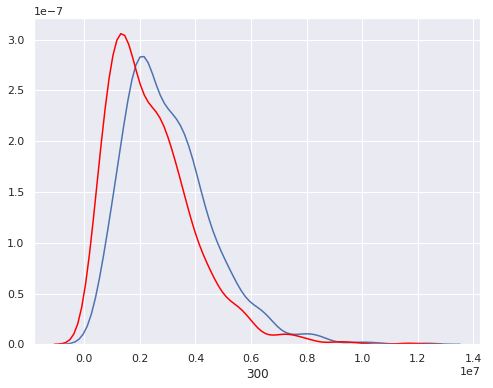

Median net worth: own 2771795.0 | rent 2088587.0
Mean net worth: own 3039590.0 | rent 2400029.0
Ttest_relResult(statistic=132.4777857717745, pvalue=0.0)
-------------------------
---------- no renter pay off house fastest ---------------


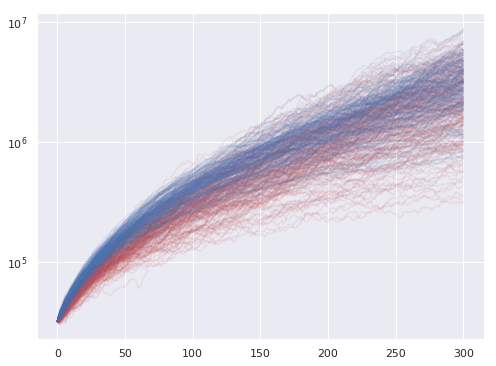

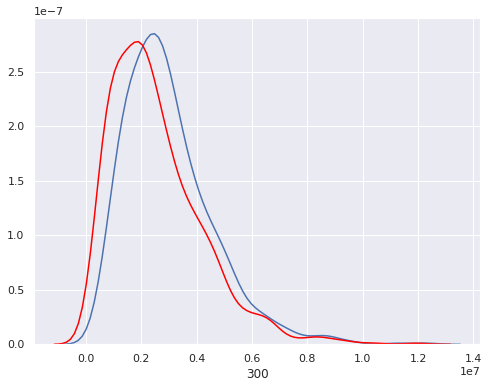

Median net worth: own 2690691.0 | rent 2180476.0
Mean net worth: own 2984167.0 | rent 2536262.0
Ttest_relResult(statistic=47.890011530109305, pvalue=5.784826915225463e-261)
-------------------------


In [14]:
print('---------- no renter baseline ---------------')
monte_carlo(1000, {'surplus_market_alloc': 0.5})
print('-------------------------')
print('---------- no renter invest all surplus in market ---------------')
monte_carlo(1000, {'surplus_market_alloc': 1})
print('-------------------------')
print('---------- no renter pay off house fastest ---------------')
monte_carlo(1000, {'surplus_market_alloc': 0})
print('-------------------------')

## Add a renter!

---------- renter baseline ---------------


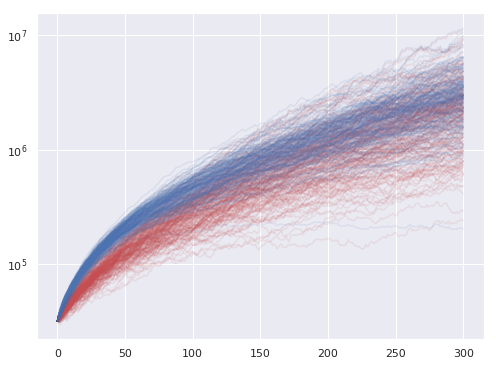

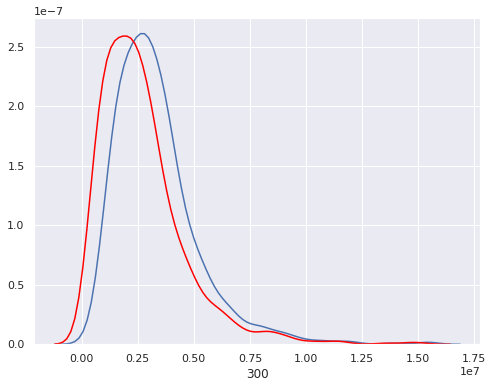

Median net worth: own 2986031.0 | rent 2332880.0
Mean net worth: own 3336778.0 | rent 2687857.0
Ttest_relResult(statistic=101.63945184448856, pvalue=0.0)
-------------------------
---------- renter invest all surplus in market ---------------


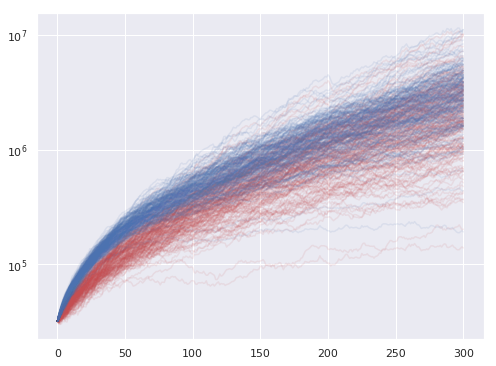

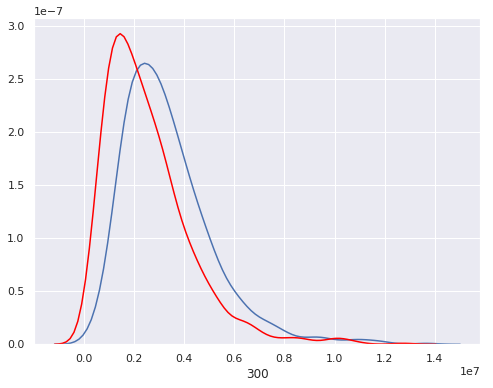

Median net worth: own 3004192.0 | rent 2188818.0
Mean net worth: own 3353210.0 | rent 2537103.0
Ttest_relResult(statistic=147.43740036916154, pvalue=0.0)
-------------------------
---------- renter pay off house fastest ---------------


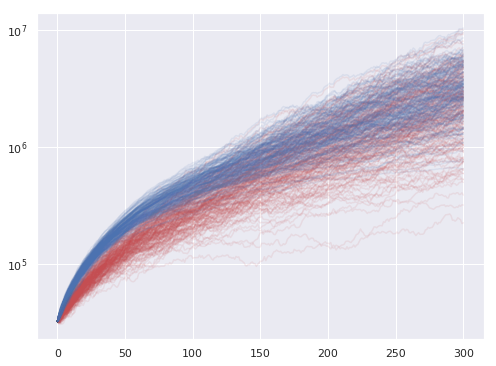

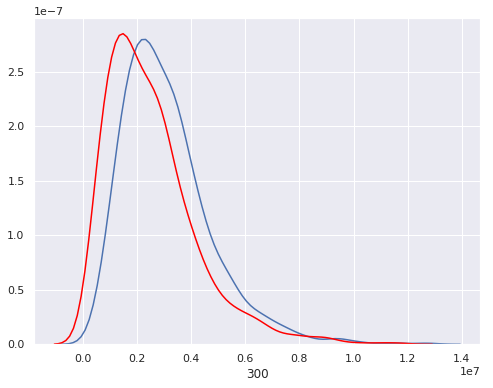

Median net worth: own 2786804.0 | rent 2204861.0
Mean net worth: own 3112109.0 | rent 2526671.0
Ttest_relResult(statistic=65.4202003624108, pvalue=0.0)
-------------------------
---------- long renter ---------------


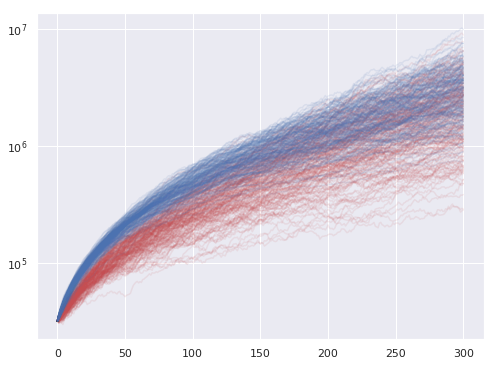

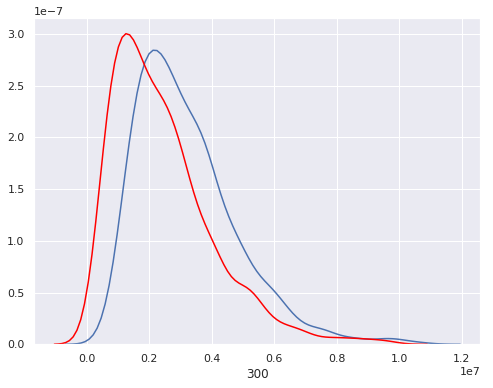

Median net worth: own 2878943.0 | rent 2099781.0
Mean net worth: own 3196893.0 | rent 2419277.0
Ttest_relResult(statistic=127.44913132813402, pvalue=0.0)
-------------------------
---------- long renter all surplus in market---------------


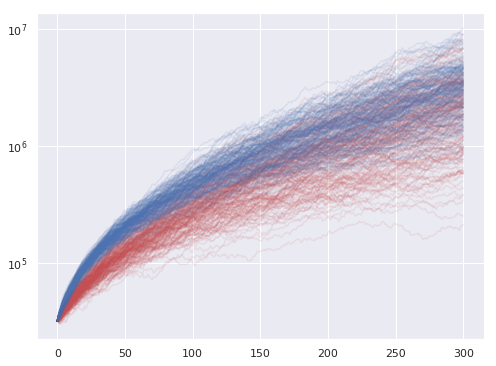

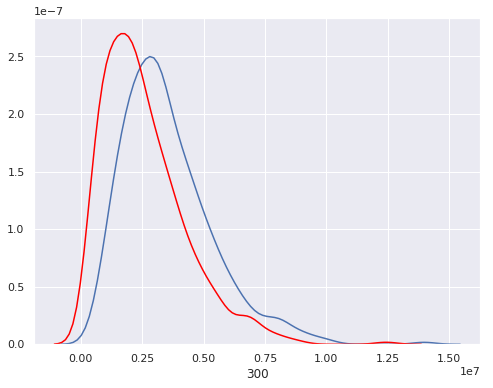

Median net worth: own 3208016.0 | rent 2240509.0
Mean net worth: own 3541160.0 | rent 2590978.0
Ttest_relResult(statistic=139.0410718825568, pvalue=0.0)
-------------------------


In [15]:
print('---------- renter baseline ---------------')
monte_carlo(1000, {'surplus_market_alloc': 0.5, 'rental_income': 700, 'years_renting': 5})
print('-------------------------')
print('---------- renter invest all surplus in market ---------------')
monte_carlo(1000, {'surplus_market_alloc': 1, 'rental_income': 700, 'years_renting': 5})
print('-------------------------')
print('---------- renter pay off house fastest ---------------')
monte_carlo(1000, {'surplus_market_alloc': 0, 'rental_income': 700, 'years_renting': 5})
print('-------------------------')
print('---------- long renter ---------------')
monte_carlo(1000, {'surplus_market_alloc': 0.5, 'rental_income': 700, 'years_renting': 10})
print('-------------------------')
print('---------- long renter all surplus in market---------------')
monte_carlo(1000, {'surplus_market_alloc': 1, 'rental_income': 700, 'years_renting': 10})
print('-------------------------')

## Better market returns with renter

---------- renter baseline ---------------


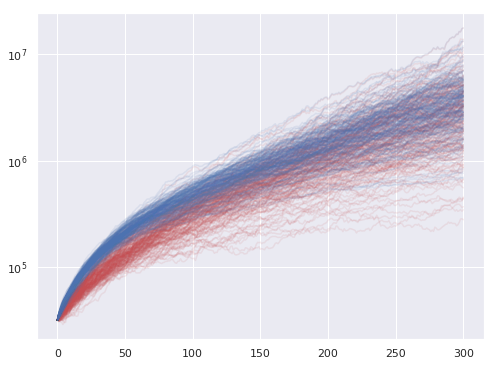

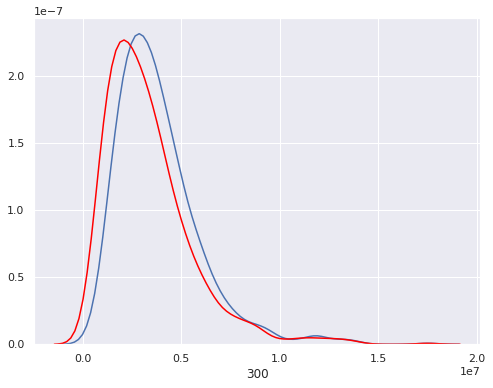

Median net worth: own 3434253.0 | rent 2888703.0
Mean net worth: own 3846481.0 | rent 3322949.0
Ttest_relResult(statistic=63.7273026036559, pvalue=0.0)
-------------------------
---------- renter invest all surplus in market ---------------


In [ ]:
print('---------- renter baseline ---------------')
monte_carlo(1000, {'surplus_market_alloc': 0.5, 'rental_income': 700, 'years_renting': 5, 'expected_market_return': 1.08})
print('-------------------------')
print('---------- renter invest all surplus in market ---------------')
monte_carlo(1000, {'surplus_market_alloc': 1, 'rental_income': 700, 'years_renting': 5, 'expected_market_return': 1.08})
print('-------------------------')
print('---------- long renter all surplus in market---------------')
monte_carlo(1000, {'surplus_market_alloc': 1, 'rental_income': 700, 'years_renting': 10, 'expected_market_return': 1.08})
print('-------------------------')

## Home appreciates 1% more than inflation

In [ ]:
print('---------- home appreciation baseline ---------------')
monte_carlo(1000, {'surplus_market_alloc': 0.5, 'expected_home_appreciation': 1.03})
print('-------------------------')
print('---------- home appreciation all surplus in market ---------------')
monte_carlo(1000, {'surplus_market_alloc': 1, 'expected_home_appreciation': 1.03})
print('-------------------------')
print('---------- home appreciation pay off house fastest ---------------')
monte_carlo(1000, {'surplus_market_alloc': 0, 'expected_home_appreciation': 1.03})
print('-------------------------')

## Home appreciates 1% less than inflation

In [ ]:
print('---------- home depreciation baseline ---------------')
monte_carlo(1000, {'surplus_market_alloc': 0.5, 'expected_home_appreciation': 1.01})
print('-------------------------')
print('---------- home depreciation all surplus in market ---------------')
monte_carlo(1000, {'surplus_market_alloc': 1, 'expected_home_appreciation': 1.01})
print('-------------------------')
print('---------- home depreciation pay off house fastest ---------------')
monte_carlo(1000, {'surplus_market_alloc': 0, 'expected_home_appreciation': 1.01})
print('-------------------------')